# VI. Modeling Traffic-Collision Correspondence

Now for the moment of truth, is this data actually something we can accurately model?

In [2]:
import geopandas as gpd
data = gpd.read_file("../data/interm/aadt_mvc_combined.geojson")

In [3]:
data.head()

,AADT,AADT_TYPE,AADT_YEAR,AMVC_END,AMVC_START,BMP,BegDesc,END_ERROR,EP,EndDesc,...,MUNI,MVC_END_X,MVC_END_Y,MVC_START_X,MVC_START_Y,RC_ID,ROADWAYTYP,START_ERROR,Shape_Leng,geometry
0,7847,FORECAST,2014,6.597805,6.833441,0.0,JEROME AVE,2.820690,1.09,UNIVERSITY AVE,...,City of Bronx,-73.923623,40.844237,-73.931225,40.829478,01_2030,Road,24.951617,1744.861678,LINESTRING Z (-73.93109203821405 40.8296789857...
1,5383,FORECAST,2014,0.471272,35.345384,0.0,E TREMONT AVE,0.773816,1.23,E KINGSBRDG RD,...,City of Bronx,-73.894025,40.864892,-73.901022,40.847667,01_2024,Road,60.139634,1981.682023,LINESTRING Z (-73.90146605153026 40.8480909803...
2,21308,FORECAST,2014,0.235636,31.103938,2.6,WHITE PLAINS R,21.152265,3.48,SILVER ST,...,City of Bronx,-73.848478,40.843024,-73.864478,40.841087,01_1167,Road,27.291144,1415.639161,LINESTRING Z (-73.86477260758522 40.8409845678...
3,15699,FORECAST,2014,25.684312,34.874112,0.4,BOSTON RD,2.465165,0.92,E 233RD ST,...,City of Bronx,-73.841962,40.888456,-73.838742,40.881266,01_1106,Road,5.197127,836.201775,LINESTRING Z (-73.83876496360224 40.8813099830...
4,8344,FORECAST,2014,7.304713,14.373790,0.6,METCALF AVE,3.742979,1.42,PUGSLEY AVE,...,City of Bronx,-73.855649,40.824632,-73.871002,40.822562,01_2043,Road,2.338001,1316.331740,LINESTRING Z (-73.87097401539016 40.8225599646...


Ok, so first of all the problem we saw all the way back when we were still getting into this: `AMVC_END` and `AMVC_START` correspondence is highly iffy.

In [5]:
data[['AMVC_END', 'AMVC_START']].head()

,AMVC_END,AMVC_START
0,6.597805,6.833441
1,0.471272,35.345384
2,0.235636,31.103938
3,25.684312,34.874112
4,7.304713,14.373790


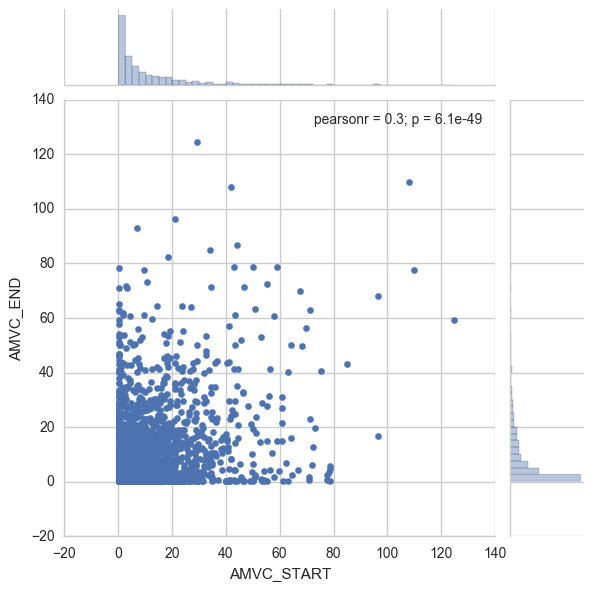

In [8]:
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.jointplot('AMVC_START', 'AMVC_END', data=data)

This is very weak correspondence, and smaller samples display that this is a microstructure.

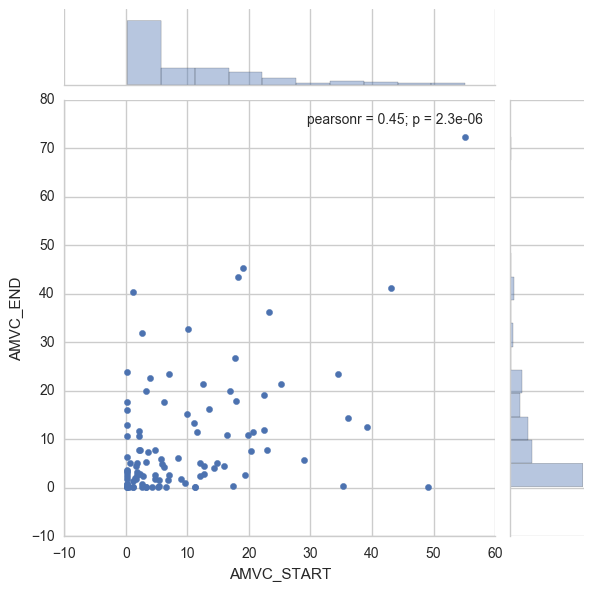

In [10]:
sns.jointplot('AMVC_START', 'AMVC_END', data=data.sample(100))

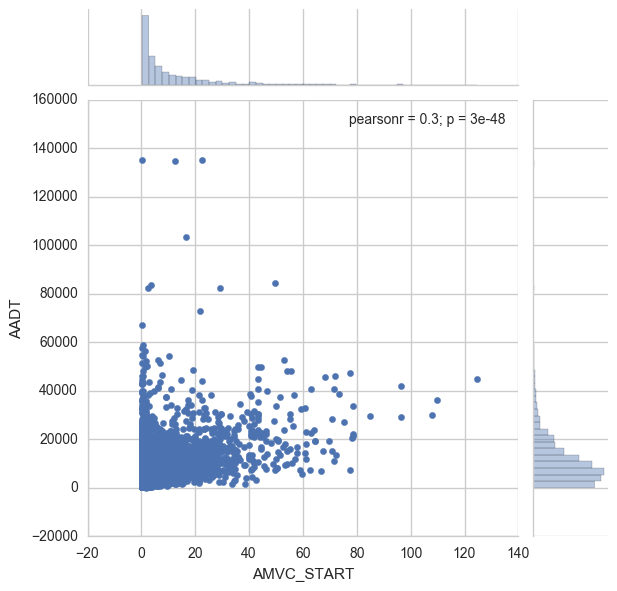

In [12]:
sns.jointplot(data['AMVC_START'], data['AADT'].astype(float))

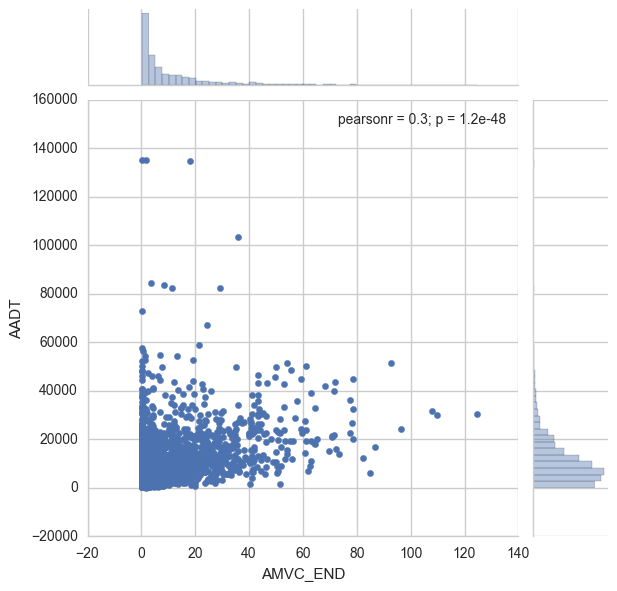

In [15]:
sns.jointplot(data['AMVC_END'].astype(float), data['AADT'].astype(float))

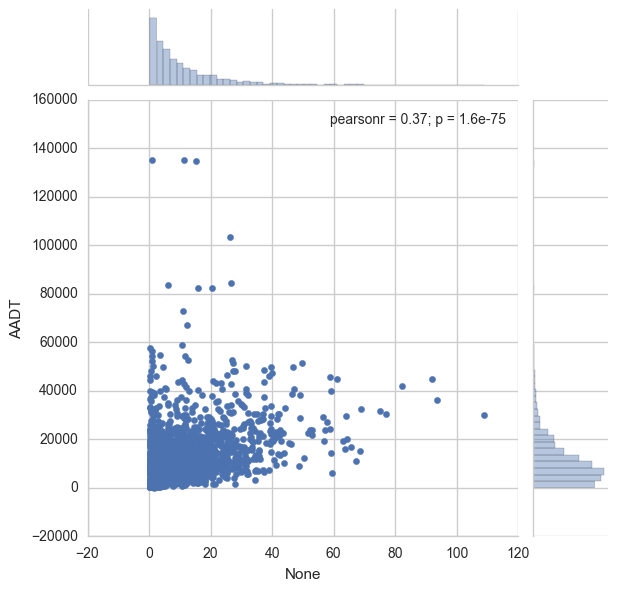

In [16]:
sns.jointplot((data['AMVC_END'].astype(float) + data['AMVC_START'].astype(float))/ 2, data['AADT'].astype(float))

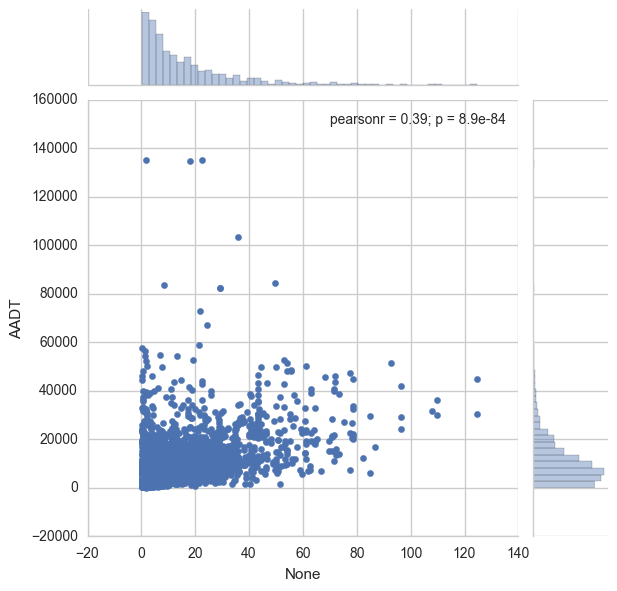

In [24]:
import numpy as np
sns.jointplot(pd.Series([np.max([a, b]) for a, b in zip(data['AMVC_END'].astype(float), data['AMVC_START'].astype(float))]), 
              data['AADT'].astype(float))

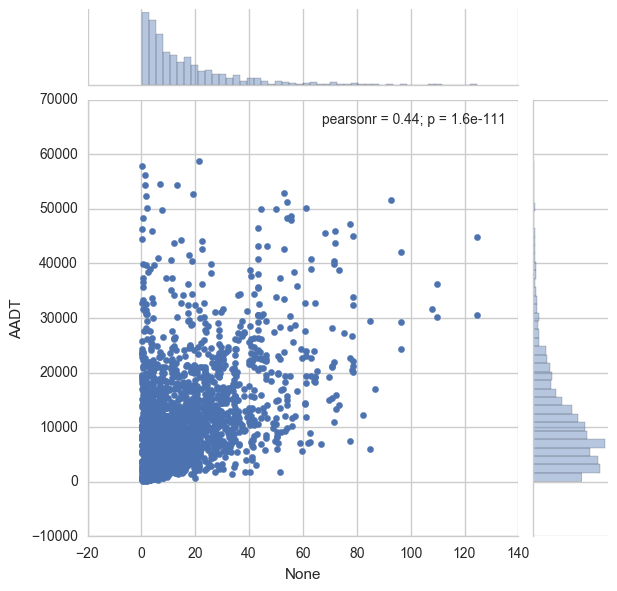

In [35]:
import numpy as np
max_mvc = pd.Series([np.max([a, b]) for a, b in zip(data['AMVC_END'].astype(float), data['AMVC_START'].astype(float))])
max_mvc_sub_60k = max_mvc.iloc[max_mvc[data['AADT'].astype(float) < 60000].index]

sns.jointplot(max_mvc_sub_60k, data['AADT'][data['AADT'].astype(float) < 60000].astype(float))

The "take the maximum" strategy seems most promising, and removing high-`AADT` streets from consideration seems to help as well. This seems OK to do because remember, we're trying to model local streets, and local streets are going to construe closer to moderately large-traffic streets than exceptionally large-traffic ones.

I find points so far up and to the left to be really suspect indeed, as everything I saw previously showed a strong concordence between traffic volume and accident rate. These absolutely must be mismatches between .

We can push this "low volume" hypothesis more aggressively, but it turns out that we don't gain much explanatory power pushing down any further:

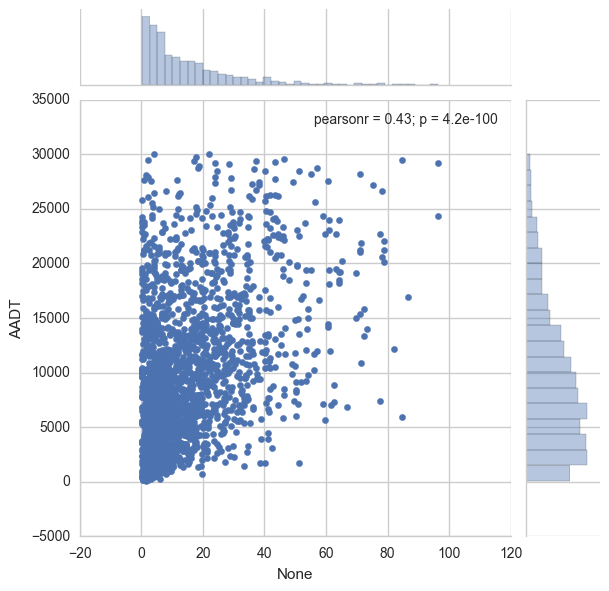

In [36]:
import numpy as np
max_mvc_sub_30k = max_mvc.iloc[max_mvc[data['AADT'].astype(float) < 30000].index]
sns.jointplot(max_mvc_sub_30k, data['AADT'][data['AADT'].astype(float) < 30000].astype(float))

In fact we're losing power (and biasing the result) because we're neglecting to remove scatters to the right.

In [43]:
import statsmodels.api as sm
# spector_data = sm.datasets.spector.load()
# spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(data['AADT'][data['AADT'].astype(float) < 60000].astype(float), max_mvc_sub_60k)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   AADT   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2672.
Date:                Mon, 03 Oct 2016   Prob (F-statistic):               0.00
Time:                        16:40:35   Log-Likelihood:                -24405.
No. Observations:                2298   AIC:                         4.881e+04
Df Residuals:                    2297   BIC:                         4.882e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           468.9707      9.073     51.687      0.0

An $r^2$ of 54% is perhaps not good enough for any statistical assay, but it ought to be good enough for a simple map. 

Errors almost certainly stem from the fuzziness of our matching protocol.

The combined formula is $0 + 468.9707*\max{(\{mvc_{start},mvc_{end}\})}$.

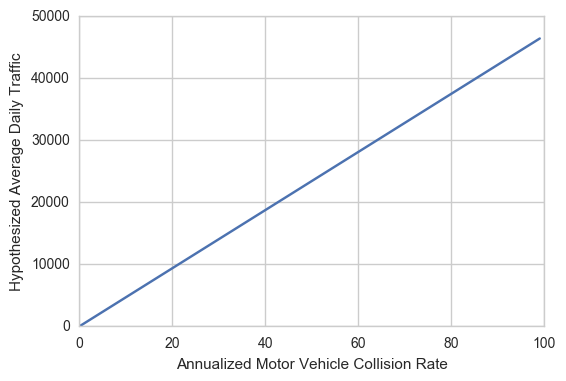

In [46]:
import matplotlib.pyplot as plt
plt.plot(range(0, 100), [468.9707 * r for r in range(0, 100)])
plt.xlabel("Annualized Motor Vehicle Collision Rate")
plt.ylabel("Hypothesized Average Daily Traffic")

Some interesting resultant observations:

In [66]:
print("{0:.8f} collisions/street driven for cars in New York City.".format(1/(468.9707*365)))
print("You can expect to drive down ~{0:.0f} streets before experiencing an accident.".format(1/0.00000584))

0.00000584 collisions/street driven for cars in New York City.
You can expect to drive down ~171233 streets before experiencing an accident.


Onwards!

Now to apply our model. We'll do something very similar to what we did when we were building the model. First, we'll need to match individual road segments with their accident rate data.

In [67]:
lion = gpd.read_file("../data/lion/nyclion_15c.shp")

In [69]:
lion.head()

,ArcCenterX,ArcCenterY,BOE_LGC,BikeLane,BoroBndry,ConParity,CurveFlag,FCC,FDNYID,FaceCode,...,ToLeft,ToRight,TrafDir,TrafSrc,Twisted,XFrom,XTo,YFrom,YTo,geometry
0,0,0,1,None,None,None,None,None,None,2510,...,699,716,T,DOT,None,1010964,1011304,241812,241537,LINESTRING (1010964.446999997 241812.261399999...
1,0,0,1,None,None,None,None,None,None,7984,...,98,99,A,DOT,None,1011577,1011335,255024,255164,"LINESTRING (1011576.6866 255023.5830000043, 10..."
2,0,0,1,None,None,None,None,None,None,7280,...,1079,1084,W,DOT,None,1011601,1011786,239640,240230,LINESTRING (1011600.676200002 239639.742799997...
3,0,0,1,None,None,None,None,None,None,7280,...,0,0,W,DOT,None,1011601,1011786,239640,240230,LINESTRING (1011600.676200002 239639.742799997...
4,0,0,1,None,None,None,None,None,None,1876,...,4645,4664,T,DOT,None,1009974,1009974,264857,265527,LINESTRING (1009974.212799996 264857.139200002...


Let's convert to the proper CRS.

In [97]:
lion_c = lion[lion['geometry'].notnull()].to_crs({'init': 'epsg:4326'})

A little more simply, all objects are `LineString` objects this time around.

In [71]:
lion['geometry'].map(type).value_counts()

<class 'shapely.geometry.linestring.LineString'>    214887
Name: geometry, dtype: int64

We need to convert the coord pairs out of Long Island State Plane, which is what LION is in, along the way.

In [100]:
def street_to_coord_pair(street):
    return street.coords[0], street.coords[-1]

coord_pairs = lion_c['geometry'].map(street_to_coord_pair) # (f.coords[0], f.coords[-1]))

Everything else is again just about the same, so if you get lost here reference notebook `05`.

In [101]:
coord_pairs.head()

0    ((-73.90346685864002, 40.83035379645732), (-73...
1    ((-73.90120067721222, 40.86661307816506), (-73...
2    ((-73.901176691262, 40.824388909173535), (-73....
3    ((-73.901176691262, 40.824388909173535), (-73....
4    ((-73.9069566348925, 40.89360793520161), (-73....
Name: geometry, dtype: object

In [78]:
import pandas as pd
mvc = pd.read_csv("../data/mvc/mvc_coordinate_counts.csv", header=None)

In [82]:
mvc.columns = ['Coordinates', 'Collisions']
mvc['Coordinates'] = mvc['Coordinates'].map(eval)

In [83]:
mvc.head()

,Coordinates,Collisions
0,"(40.4989488, -74.2443651)",2
1,"(40.4991346, -74.2434848)",1
2,"(40.4994787, -74.2417278)",1
3,"(40.499659, -74.2408224)",1
4,"(40.499842, -74.2399169)",2


In [84]:
import rtree
idx = rtree.index.Index()
for ind, coord in enumerate(mvc['Coordinates']):
    idx.insert(ind, (coord[1], coord[0], coord[1], coord[0]))  # (left, bottom, right, top)

In [102]:
nearest_start_coord = []
nearest_start_coord_collision_count = []
nearest_end_coord = []
nearest_end_coord_collision_count = []
from tqdm import tqdm_notebook
for first_coord, second_coord in tqdm_notebook(coord_pairs):
    s_x, s_y = first_coord
    e_x, e_y = second_coord
    s_ind = list(idx.nearest((s_x, s_y, s_x, s_y), 1))[0]
    s_mvc_entry = mvc.iloc[s_ind]
    nearest_start_coord.append(s_mvc_entry['Coordinates'])
    nearest_start_coord_collision_count.append(s_mvc_entry['Collisions'])
    e_ind = list(idx.nearest((e_x, e_y, e_x, e_y), 1))[0]
    e_mvc_entry = mvc.iloc[e_ind]
    nearest_end_coord.append(e_mvc_entry['Coordinates'])
    nearest_end_coord_collision_count.append(e_mvc_entry['Collisions'])

In [123]:
lion_cs = lion_c.copy()
lion_cs['mvc_start_coord'] = nearest_start_coord
lion_cs['mvc_end_coord'] = nearest_end_coord
lion_cs['mvc_start'] = nearest_start_coord_collision_count
lion_cs['mvc_end'] = nearest_end_coord_collision_count
lion_cs.head()

,ArcCenterX,ArcCenterY,BOE_LGC,BikeLane,BoroBndry,ConParity,CurveFlag,FCC,FDNYID,FaceCode,...,Twisted,XFrom,XTo,YFrom,YTo,geometry,mvc_start_coord,mvc_end_coord,mvc_start,mvc_end
0,0,0,1,None,None,None,None,None,None,2510,...,None,1010964,1011304,241812,241537,LINESTRING (-73.90346685864002 40.830353796457...,"(40.8303531, -73.9034685)","(40.8295972, -73.902241)",36,39
1,0,0,1,None,None,None,None,None,None,7984,...,None,1011577,1011335,255024,255164,LINESTRING (-73.90120067721222 40.866613078165...,"(40.8666142, -73.9011995)","(40.8669992, -73.9020739)",12,15
2,0,0,1,None,None,None,None,None,None,7280,...,None,1011601,1011786,239640,240230,LINESTRING (-73.90117669126199 40.824388909173...,"(40.8243896, -73.9011755)","(40.8260084, -73.9005047)",9,16
3,0,0,1,None,None,None,None,None,None,7280,...,None,1011601,1011786,239640,240230,LINESTRING (-73.90117669126199 40.824388909173...,"(40.8243896, -73.9011755)","(40.8260084, -73.9005047)",9,16
4,0,0,1,None,None,None,None,None,None,1876,...,None,1009974,1009974,264857,265527,LINESTRING (-73.9069566348925 40.8936079352016...,"(40.8936076, -73.9069574)","(40.8956017, -73.90817)",1,3


Looking good! As usual, there's a long tail.

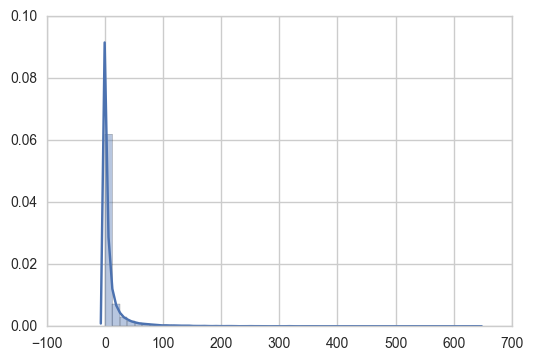

In [124]:
import numpy as np
import seaborn as sns
mvc_diff = np.abs(lion_cs['mvc_start'] - lion_cs['mvc_end'])
lion_cs['mvc_diff'] = mvc_diff
sns.distplot(mvc_diff)

2% of entities in the `LION` dataset have a >100 difference in collision rate.

In [125]:
len(lion_cs.query("mvc_diff > 100")), len(lion_cs.query("mvc_diff > 100")) / len(lion_cs)

(4126, 0.019200789252025483)

We will need to refer to the LION data dictionary to see what to do to bring down this error rate and remove extraneous features.

In [120]:
import requests
with open("../figures/DCP_Lion_Data_Dictionary.pdf", "wb") as f:
    f.write(requests.get("https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/lion_metadata.pdf?r=16c").content)

In [121]:
from IPython.display import IFrame
IFrame("../figures/DCP_Lion_Data_Dictionary.pdf", width=800, height=600)

The dataset includes a field for `FeatureTyp`, which, according to the data dictionary, describes the entity's use.

In [126]:
lion_cs['FeatureTyp'].value_counts()

0    169560
3     10516
2      9212
1      7795
6      7234
A      3806
7      2913
8      1599
W      1013
9       910
5       290
C        39
Name: FeatureTyp, dtype: int64

We want only `FeatureTyp == 0`:

> VALUE 0
>
> DESCRIPTION Street other than vehicle only street.

In [137]:
lion_csf = lion_cs[lion_cs['FeatureTyp'] == "0"]

In [130]:
len(lion_csf)

169560

The next article of interest is `SegmentType`, which includes information on road segments. These are rather hard to parse, but the one we clearly don't want is `E`, which is an entrance or ramp.

This data seems to be duplicated in the more comprehensive `RW_Type` variable, though, so let's leave it alone for the moment.

In [131]:
lion_csf['SegmentTyp'].value_counts()

U    119584
R     25632
G     12052
E      5452
F      2945
T      1647
S       859
C       812
B       577
Name: SegmentTyp, dtype: int64

On page 35 of the data dictionary, the all-important roadway type variable:

> VALUE 1
> DESCRIPTION Street

> VALUE 2
> DESCRIPTION Highway

> VALUE 3
> DESCRIPTION Bridge

> VALUE 4
> DESCRIPTION Tunnel

> VALUE 5
> DESCRIPTION Boardwalk

> VALUE 6
> DESCRIPTION Path/Trail

> VALUE 7
> DESCRIPTION Step Street

> VALUE 8
> DESCRIPTION Driveway

> VALUE 9
> DESCRIPTION Ramp

> VALUE 10
> DESCRIPTION Alley

> VALUE 11
> DESCRIPTION Unknown

> VALUE 12
> DESCRIPTION Non-Physical Street Segment

> VALUE 13
> DESCRIPTION U-Turn

> VALUE 14
> DESCRIPTION Ferry Route

In [136]:
lion_csf['RW_TYPE'].value_counts()

1     139159
2      13841
6       4058
3       2916
12      2851
13       546
4        254
9        196
8        143
5         60
7         60
14        24
Name: RW_TYPE, dtype: int64

Some earlier text states that ferry routes are included for bicycle routing, FYI. Gee, sounds familiar! It's a little difficult to determine what to keep and what to prune just off the bat:

* Keep: 1
* Prune: 2, 5, 9, 10, 11, 12, 13, 14
* Unsure: 3, 4, 6, 7, 8

Let's vet the ones we're not certain of by hand.

In [138]:
import mplleaflet
import matplotlib.pyplot as plt
ax = lion_csf.query('RW_TYPE == "3"').plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

Verdict: prune 3 (bridges).

Next, 4.

In [139]:
ax = lion_csf.query('RW_TYPE == "4"').plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

Yeah, gone. Interesting how LION splits bridges and tunnels into such an enormous amount of individual segments.

In [140]:
ax = lion_csf.query('RW_TYPE == "6"').sample(1000).plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

6 is Path/Trail, and the classification seems quite faithful, which things such as protected paths inside of lane dividers and paths within housing blocks getting the classification. For instance, here's a set of Path/Trails that are located inside in the Summer Houses, a public project:

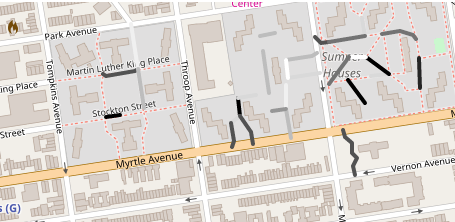

In [141]:
from IPython.display import Image
Image("../figures/LION Path Trail Example.png")

We exclude that.

In [142]:
ax = lion_csf.query('RW_TYPE == "7"').plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

What the hell is a step street? [It's actually exactly what it sounds like!](http://forgotten-ny.com/1999/06/step-streets-rare-streets-devoted-only-to-the-access-of-pedestrians-in-the-bronx/). Wow:

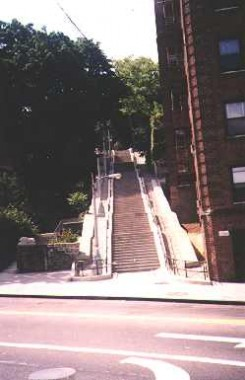

In [144]:
Image("../figures/Step Street Example.jpg")

Wowowowow. I didn't know! Well, obviously cars aren't going up that...

Last one, 8:

In [145]:
ax = lion_csf.query('RW_TYPE == "8"').plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

These are bits of car-accessible roadway which are internal to projects and other forms of city-owned land, so like trails and paths, except that cars can use them. It's best to exclude these because the way the NYPD data is constructed these are probably omitted by the geocoder.

So we keep only 1.

In [147]:
lion_csff = lion_csf.query("RW_TYPE == '1'")

None of the other fields are useful for our purposes.

In [149]:
lion_csff.head()

,ArcCenterX,ArcCenterY,BOE_LGC,BikeLane,BoroBndry,ConParity,CurveFlag,FCC,FDNYID,FaceCode,...,XFrom,XTo,YFrom,YTo,geometry,mvc_start_coord,mvc_end_coord,mvc_start,mvc_end,mvc_diff
0,0,0,1,None,None,None,None,None,None,2510,...,1010964,1011304,241812,241537,LINESTRING (-73.90346685864002 40.830353796457...,"(40.8303531, -73.9034685)","(40.8295972, -73.902241)",36,39,3
1,0,0,1,None,None,None,None,None,None,7984,...,1011577,1011335,255024,255164,LINESTRING (-73.90120067721222 40.866613078165...,"(40.8666142, -73.9011995)","(40.8669992, -73.9020739)",12,15,3
2,0,0,1,None,None,None,None,None,None,7280,...,1011601,1011786,239640,240230,LINESTRING (-73.90117669126199 40.824388909173...,"(40.8243896, -73.9011755)","(40.8260084, -73.9005047)",9,16,7
3,0,0,1,None,None,None,None,None,None,7280,...,1011601,1011786,239640,240230,LINESTRING (-73.90117669126199 40.824388909173...,"(40.8243896, -73.9011755)","(40.8260084, -73.9005047)",9,16,7
4,0,0,1,None,None,None,None,None,None,1876,...,1009974,1009974,264857,265527,LINESTRING (-73.9069566348925 40.8936079352016...,"(40.8936076, -73.9069574)","(40.8956017, -73.90817)",1,3,2


With all of that work done, the `mvc_diff` still has outliers...

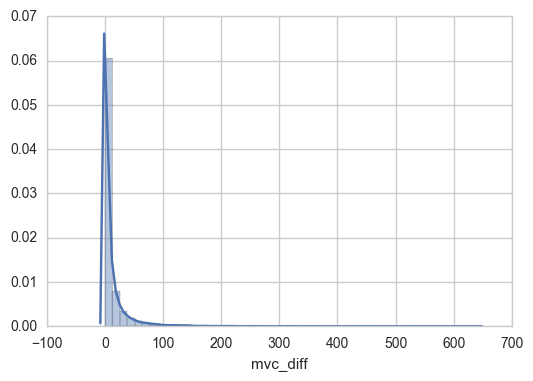

In [150]:
sns.distplot(lion_csff['mvc_diff'])

In [152]:
len(lion_csff.query("mvc_diff > 100")), len(lion_csff.query("mvc_diff > 100")) / len(lion_csff)

(2752, 0.019761455109470707)

Tut. It didn't help!

In [154]:
ax = lion_csff.query("mvc_diff > 100").sample(1000).plot()
for l in ax.lines:
    l.set_linewidth(4)
mplleaflet.display()

The errant segments are distributed randomly throughout the city. Zooming in on one group in particular, on Ocean Parkway, seems to demonstrate why:

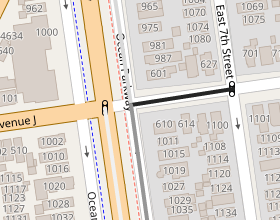

In [156]:
Image("../figures/Ocean Parkway Mismatch.png")

These occur because the geographic matching algorithm that I used is conflating high-throughput streets with low-throughput ones in cases in which they are very, very close to one another. For instance, in this example the segment of  road on Avenue J between Ocean Parkway and East 7th Street is matching with accidents which are geocoded to the nearby major intersection.

In other words, most of these cases are minor streets abutting minor streets, and getting thrown off-base for it. It's obviously not appropriate to remove these road segments; it's best instead to take the minimum of the start/end values, because that's clearly a closer match to the actual traffic rate.

For small differences (<=10), let's take the mean. For large differences (>10), let's take the minimum.

**NOTE**: At this juncture I unthinkingly forgot to do something important. I didn't multiply the `MVC` value that I select by the constant `AADT` factor that our model discovered. So instead of passing a simulated `AADT` to the `model_aadt` field, I unthinkingly just pass it the `MVC` that we select!

This is a silly error, but not killer. By the time I discovered it, I had already shut down this notebook to clear up memory, and I didn't want to rerun everything here to get up to this point. So instead I correct this error in notebook 07. Mia culpa.

In [165]:
lion_csfff = lion_csff[['geometry', 'mvc_start_coord', 'mvc_end_coord', 'mvc_start', 'mvc_end', 'mvc_diff']]

def fit_model(srs):
    if srs['mvc_diff'] > 10:
        return np.min([srs['mvc_start'], srs['mvc_end']])
    else:
        return (srs['mvc_start'] + srs['mvc_end']) / 2

lion_csfff['model_aadt'] = lion_csfff.apply(fit_model, axis='columns')

/Users/Honors/anaconda/envs/nyc-traffic-model/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


The final data is in the form of a self-similar exponential plot, as demonstrated below.

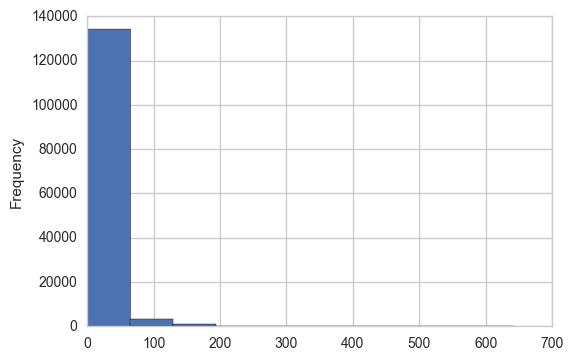

In [168]:
lion_csfff['model_aadt'].plot(kind='hist')

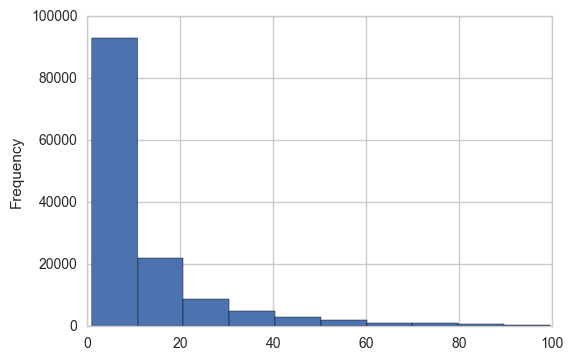

In [169]:
lion_csfff.query("model_aadt < 100")['model_aadt'].plot(kind='hist')

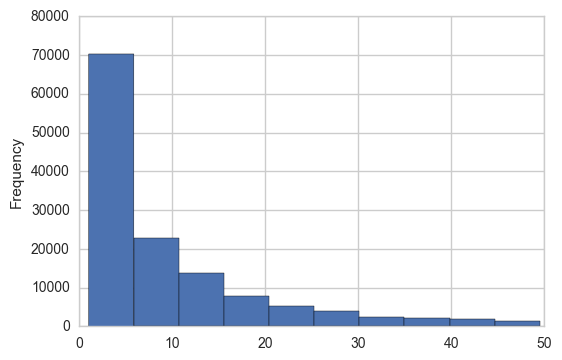

In [170]:
lion_csfff.query("model_aadt < 50")['model_aadt'].plot(kind='hist')

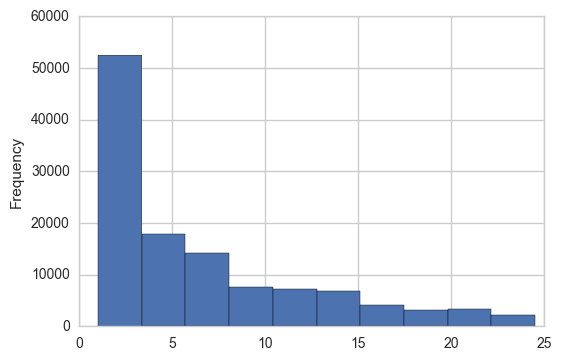

In [171]:
lion_csfff.query("model_aadt < 25")['model_aadt'].plot(kind='hist')

Convert the start and end to fields...

In [174]:
lion_csfff['mvc_start_x'] = lion_csfff['mvc_start_coord'].map(lambda c: c[1])
lion_csfff['mvc_start_y'] = lion_csfff['mvc_start_coord'].map(lambda c: c[0])
lion_csfff['mvc_end_x'] = lion_csfff['mvc_end_coord'].map(lambda c: c[1])
lion_csfff['mvc_end_y'] = lion_csfff['mvc_end_coord'].map(lambda c: c[0])

/Users/Honors/anaconda/envs/nyc-traffic-model/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Honors/anaconda/envs/nyc-traffic-model/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Honors/anaconda/envs/nyc-traffic-model/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [176]:
del lion_csfff['mvc_start_coord']
del lion_csfff['mvc_end_coord']

In [177]:
lion_csfff.head()

,geometry,mvc_start,mvc_end,mvc_diff,model_aadt,mvc_start_x,mvc_start_y,mvc_end_x,mvc_end_y
0,LINESTRING (-73.90346685864002 40.830353796457...,36,39,3,37.5,-73.903469,40.830353,-73.902241,40.829597
1,LINESTRING (-73.90120067721222 40.866613078165...,12,15,3,13.5,-73.901200,40.866614,-73.902074,40.866999
2,LINESTRING (-73.90117669126199 40.824388909173...,9,16,7,12.5,-73.901175,40.824390,-73.900505,40.826008
3,LINESTRING (-73.90117669126199 40.824388909173...,9,16,7,12.5,-73.901175,40.824390,-73.900505,40.826008
4,LINESTRING (-73.9069566348925 40.8936079352016...,1,3,2,2.0,-73.906957,40.893608,-73.908170,40.895602


In [179]:
del lion
del lion_c
del lion_cs
del lion_csf
del lion_csff

In [181]:
lion_csfff.to_file("../data/interm/aadt_mvc_combined_modelled.geojson", driver="GeoJSON")